# ODSC East Warm-Up


<h3>
Douglas Blank<br/>
Head of Research <br/>
    <a href="https://comet.ml/">Comet.ML</a> <br/>

<img src="https://comet.ml/images/logo_comet_light.png" align="left" width="200px"/>
<br clear="all"/>

doug@comet.ml, <a href="https://twitter.com/DougBlank">@DougBlank</a> <br/>
</h3>


*This Jupyter notebook is available to execute, view, or download at*

## [goo.gl/P6ia84](https://goo.gl/P6ia84)

This Jupyter notebook demonstrates a Python module in visualizing Deep Learning networks.

The module is called `ConX` and can be installed for Python 3 with:

```bash
pip install conx
```

For more information, please see [conx.readthedocs.io](https://conx.readthedocs.io)

# Goal: Train a Neural Network to Recognize Objects 

1. Train a Deep Convolutiona Neural Network on the CIFAR10 images dataset.
2. Explore the visualization capabilities of ConX

## What is ConX?

ConX is built on top of Keras. Keras is running on top of TensorFlow. 

(I'm currently running this demonstration on a Windows 10 i7 laptop with a GeForce GTX 1060 GPU).

* TensorFlow is a low-level API
* Keras is a medium-level API
* ConX is a high-level API

To use ConX, you don't need to use other complexities like numpy or matplotlib. ConX was designed to be used by students and researchers who want to focus on the Deep Learning problem to solve, rather than on side issues.

Let's get started!

After installing ConX, we can now import the module:

In [1]:
import conx as cx

Using TensorFlow backend.
ConX, version 3.7.7


Our goal is to learn to recognize images from the CIFAR-10 dataset. We can easily get the dataset through ConX:

In [2]:
cifar10 = cx.Dataset.get("cifar10")

The Dataset object in ConX has some easy to use properties. First, it can describe itself:

In [3]:
cifar10.info()

**Dataset**: CIFAR-10


Original source: https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10
classes, with 6000 images per class.

The classes are completely mutually exclusive. There is no overlap
between automobiles and trucks. "Automobile" includes sedans, SUVs,
things of that sort. "Truck" includes only big trucks. Neither
includes pickup trucks.

**Information**:
   * name    : CIFAR-10
   * length  : 60000

**Input Summary**:
   * shape  : (32, 32, 3)
   * range  : (0.0, 1.0)

**Target Summary**:
   * shape  : (10,)
   * range  : (0.0, 1.0)



## Examine Dataset Vectors as Images

The Dataset has two main properties: inputs, and targets. Let's check out the shape of the inputs:

In [4]:
cifar10.inputs.shape

[(32, 32, 3)]

Notice that Dataset.inputs.shape gave us (32, 32, 3) in a list. This is because inputs could be composed of more that one bank of values. In this case, there is just one bank, composed of 32 x 32 x 3 values:

In [5]:
32 * 32 * 3

3072

Likewise, let's examine the targets:

In [6]:
cifar10.targets.shape

[(10,)]

If you have seen the CIFAR-10 dataset before, you might guess that the targets are a one-hot representation of the category of the image. Let's visualize the first input pattern:

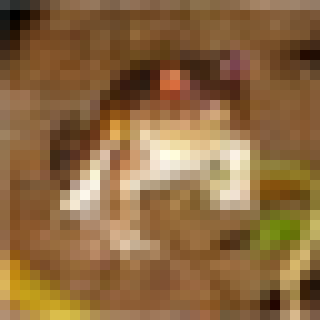

In [7]:
image = cx.array_to_image(cifar10.inputs[0], scale=10)
image

Here we used an index on `cifar10.inputs` and pass it to the `cx.array_to_image` function. It is a frog!

Let's see what the target is:

In [8]:
cifar10.targets[0]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]

We can also turn the targets into a image as well

In [9]:
cx.array_to_image(cifar10.targets[0], scale=20)

It looks like when cifar10.targets[i][6] == 1.0, then that is a frog. Let's see a few frogs. How many frogs are in the first 100 input patterns?

In [10]:
frogs = [i for i in range(100) if cifar10.targets[i][6] == 1]

We can use cx.array_to_image again, and combine it with cx.view, a versatile visualizer that even works from the IPython console:

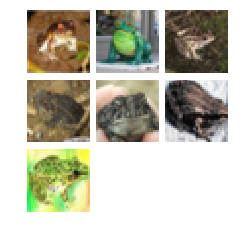

In [11]:
cx.view([cx.array_to_image(v) for v in cifar10.inputs[frogs]])

Seven frogs in the first 100 images. We can see the first 100 with:

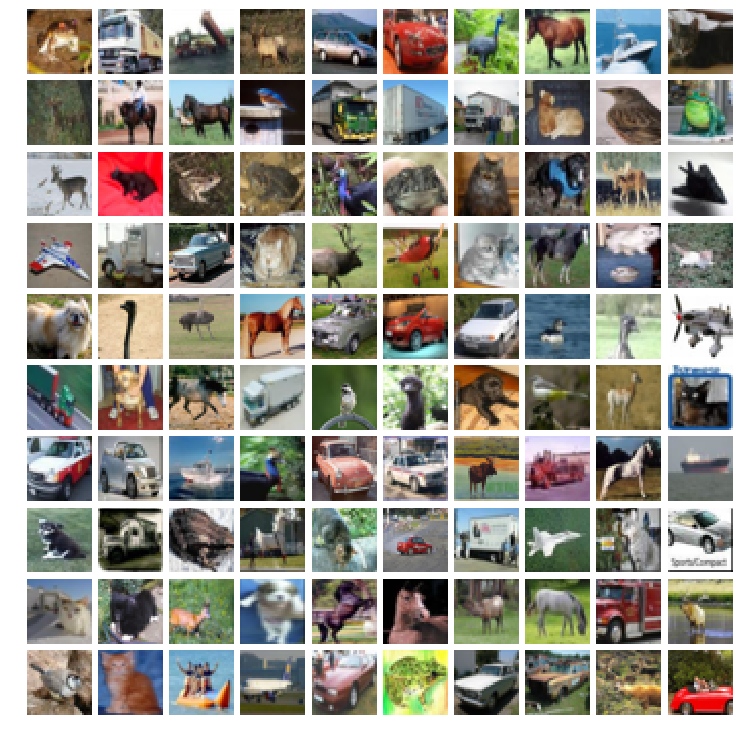

In [12]:
cx.view([cx.array_to_image(v) for v in cifar10.inputs[:100]])

## The Network

Now that we know what the inputs and targets look like, we can build a model. This is a `Network` in ConX terms. We add a series of layers, using names that are similar to many Deep Learning libraries:

In [13]:
net = cx.Network("CIRAR10")
net.add(
    cx.ImageLayer("input", (32, 32), 3), 
    cx.Conv2DLayer("conv1", 32, (3, 3), padding='same', activation='relu'),
    cx.Conv2DLayer("conv2", 32, (3, 3), activation='relu'),
    cx.MaxPool2DLayer("pool1", pool_size=(2, 2), dropout=0.25),
    cx.Conv2DLayer("conv3", 64, (3, 3), padding='same', activation='relu'),
    cx.Conv2DLayer("conv4", 64, (3, 3), activation='relu'),
    cx.MaxPool2DLayer("pool2", pool_size=(2, 2), dropout=0.25),
    cx.FlattenLayer("flatten"),
    cx.Layer("hidden1", 512, activation='relu', vshape=(16, 32), dropout=0.5),
    cx.Layer("hidden2", 50, activation='relu', vshape=(10, 5), dropout=0.5),
    cx.Layer("output", 10, activation='softmax'),
)
net.connect()

Some things to notice:

1. Everything in ConX requires a name
1. ImageLayer is a special InputLayer designed to visualize images
1. Layer is generic; it can be used as an InputLayer or a DenseLayer 
1. Activation, and dropout can be provided as named parameters to a layer
1. vshape is a the visual shape of the layer, as we will see
1. Because the layers are added in order, we can connect them all at once using `net.connect()`

Now we need to `compile` the Network. We use "categorical_crossentropy" as an error measure, which matches the "softmax" activation of the output layer. If we didn't have a softmax/crossentropy match, ConX would issue a warning.

In [14]:
net.compile(error='categorical_crossentropy',
            optimizer='rmsprop', lr=0.0001, decay=1e-6)

Now, we can use the cirfar10 dataset with the network:

In [15]:
net.set_dataset(cifar10)

If the sizes of the dataset inputs and targets didn't match the sizes of the network input and output banks, then ConX would issue an error.

Now, we are ready to split the dataset into training and testing sets. We use the split() method to save 10% for testing/validation. 

Before we do that, let's trim this dataset down... a whole lot... to make training go fast for this demo:

In [16]:
net.dataset.chop(59000)
net.dataset.split(0.1)
net.dataset.split()

(900, 100)

# Visualizing Activations

In [17]:
net.propagate(net.dataset.inputs[0])

[0.09929478913545609,
 0.10617978125810623,
 0.10472368448972702,
 0.0984770879149437,
 0.09838621318340302,
 0.09901992976665497,
 0.10065734386444092,
 0.0959383174777031,
 0.09833462536334991,
 0.09898822754621506]


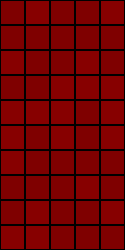
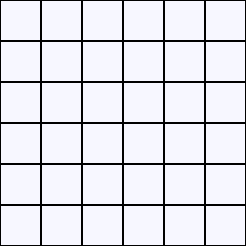
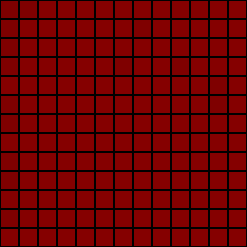
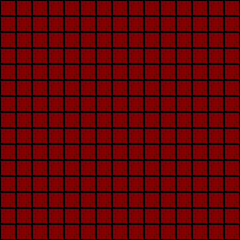
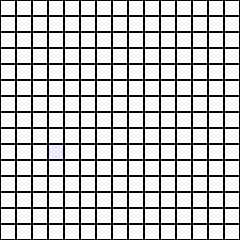
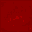
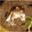

In [18]:
net.picture(net.dataset.inputs[0])


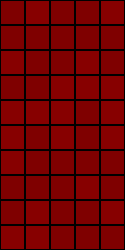
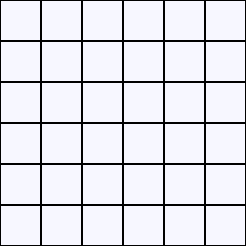
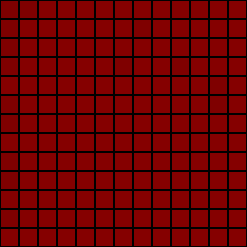
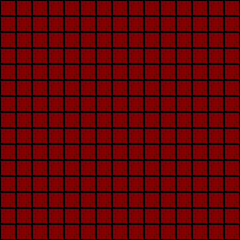
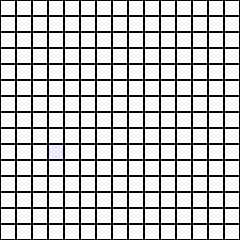
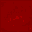
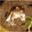

In [19]:
net.picture(net.dataset.inputs[0], scale=0.5)

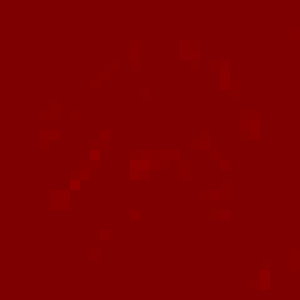

In [20]:
net.propagate_to_image("conv2", net.dataset.inputs[0], scale=10)

So, we will train on 900 images, and save 100 for testing.

Before we train, one more tool to show: the Network dashboard:

In [21]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

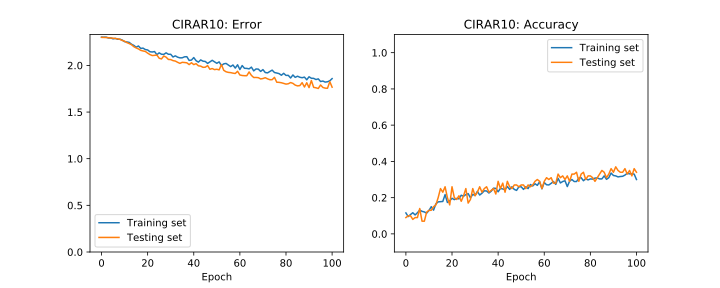

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#  100 |   1.85829 |   0.30000 |   1.76636 |   0.34000 


In [22]:
net.train(100, batch_size=256, record=1)

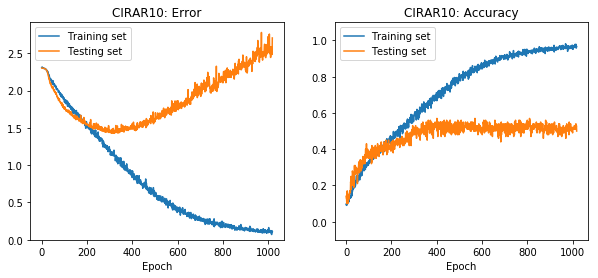

In [23]:
net.load()
net.plot_results()

SequenceViewer(children=(VBox(children=(HBox(children=(IntSlider(value=0, continuous_update=False, description…

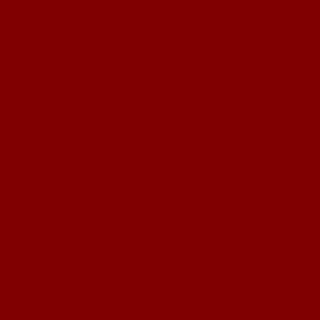

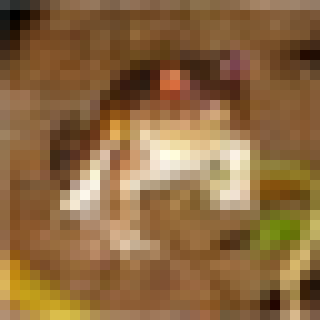

In [24]:
def function(network, epoch):
    return net.propagate_to_image("conv1", net.dataset.inputs[0], scale=10), image

net.playback(function)

In [25]:
#net.reset()
#net.train(1000, batch_size=256, record=1)
#net.save()


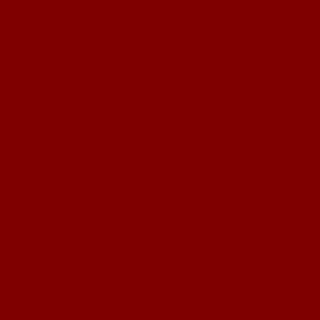
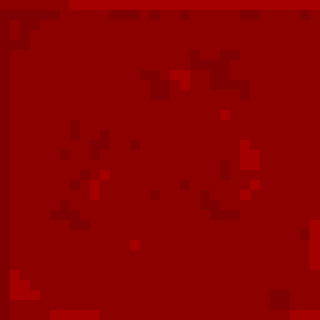
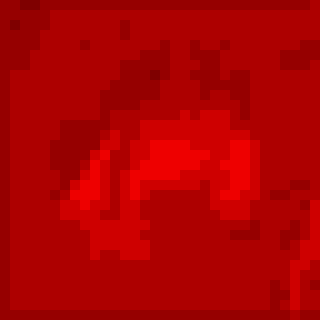
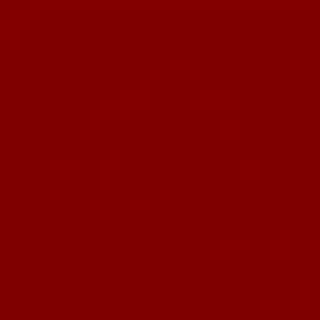
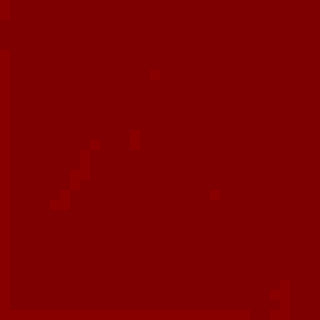
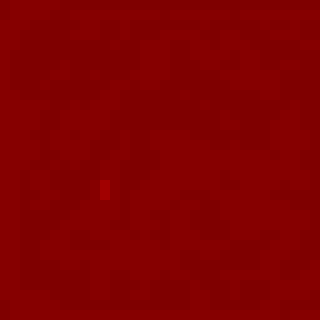
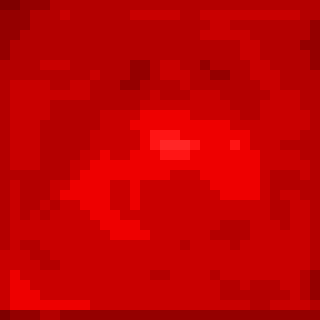
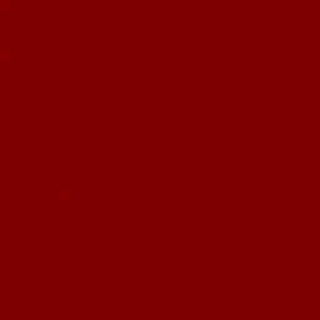
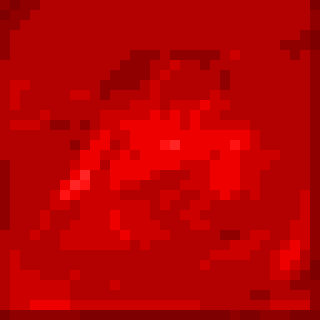
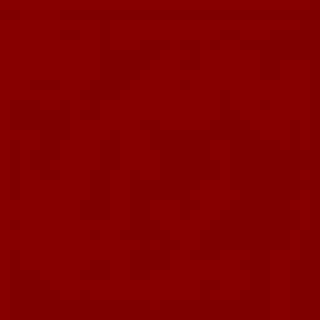
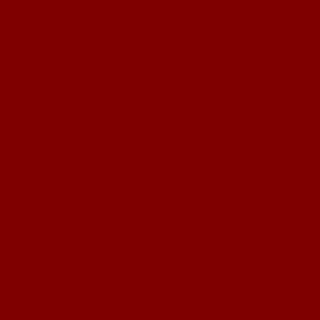
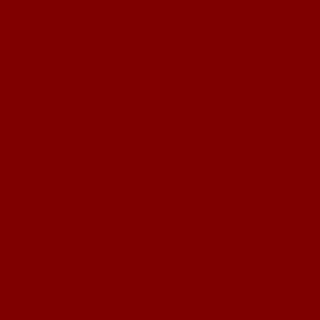
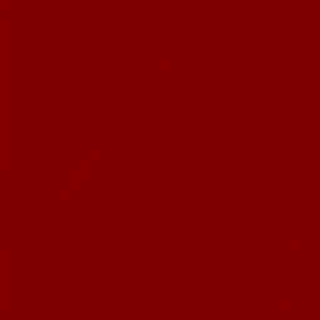
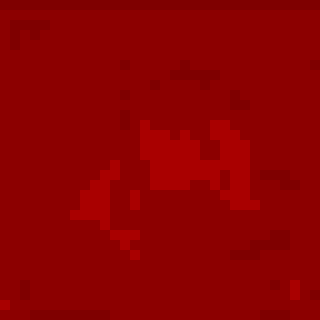
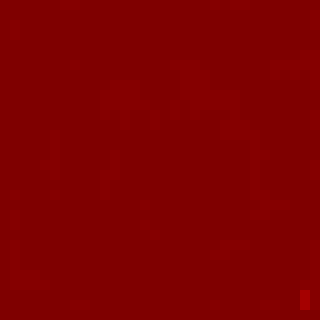
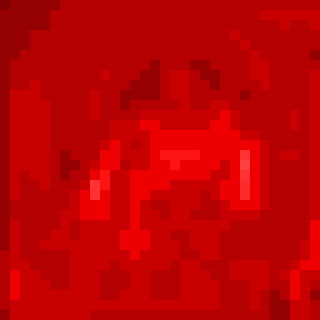
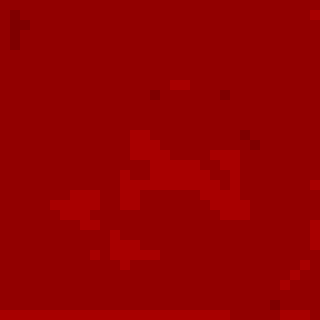
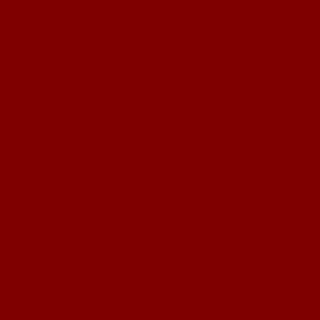
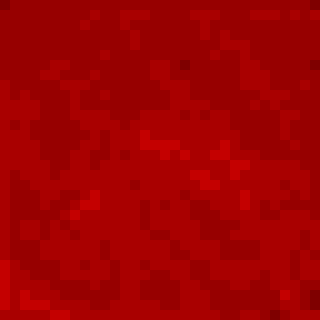
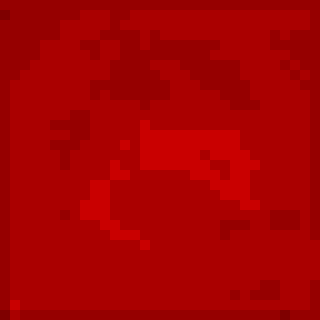
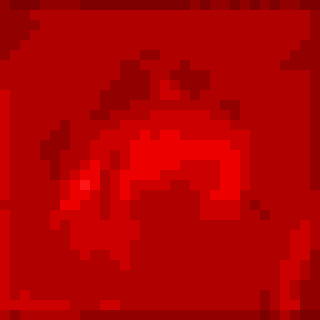
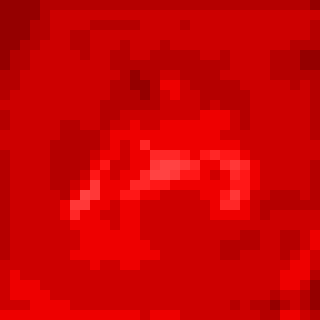
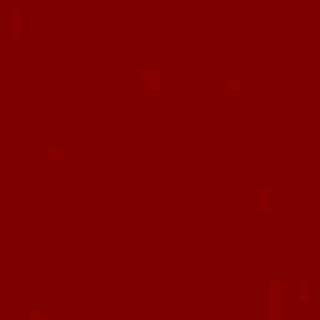
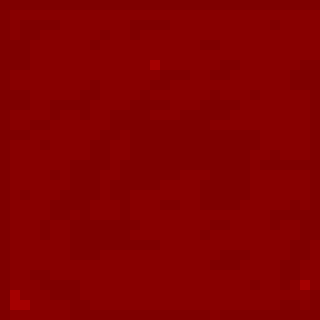
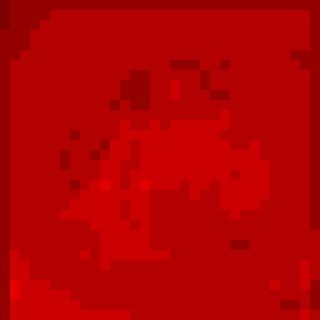
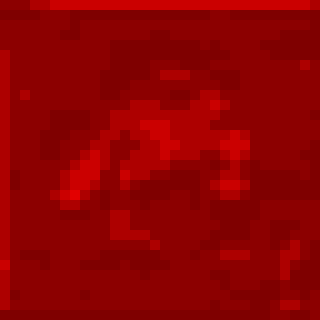
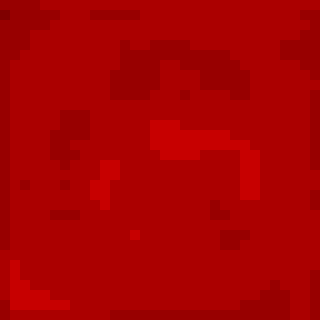
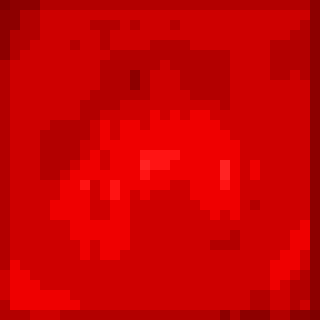
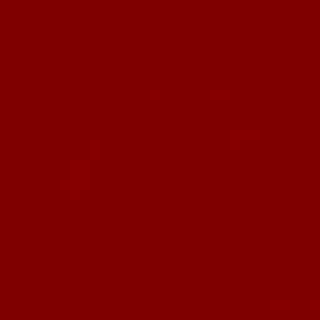
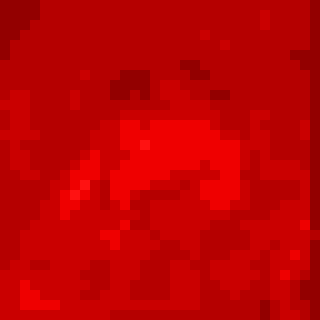
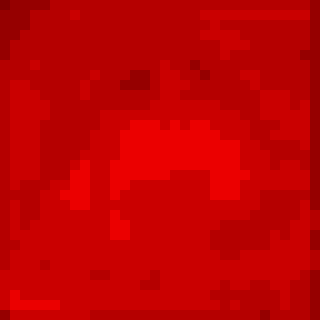
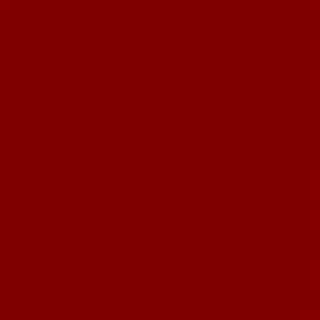

In [26]:
net.propagate_to_features("conv1", net.dataset.inputs[0], scale=10)

In [27]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

# ODSC East Warm-Up


<h3>
Douglas Blank<br/>
Head of Research <br/>
    <a href="https://comet.ml/">Comet.ML</a> <br/>

<img src="https://comet.ml/images/logo_comet_light.png" align="left" width="200px"/>
<br clear="all"/>

doug@comet.ml, <a href="https://twitter.com/DougBlank">@DougBlank</a> <br/>
</h3>


*This Jupyter notebook is available to execute, view, or download at*

## [goo.gl/P6ia84](https://goo.gl/P6ia84)

This Jupyter notebook demonstrates a Python module in visualizing Deep Learning networks.

The module is called `ConX` and can be installed for Python 3 with:

```bash
pip install conx
```

For more information, please see [conx.readthedocs.io](https://conx.readthedocs.io)